In [ ]:
!pip install transformers datasets torch pandas ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from ray import tune
from ray.train import report
from ray.tune.schedulers import ASHAScheduler

In [ ]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=28)
model.config.pad_token_id = model.config.eos_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X_train = train_df["text"].tolist()
y_train = train_df["labels"].tolist()

X_val = val_df["text"].tolist()
y_val = val_df["labels"].tolist()

In [ ]:
X_test = test_df["text"].tolist()
y_test = test_df["labels"].tolist()

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return {
            "input_ids": encoded["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": label,
        }

train_dataset = SentimentDataset(X_train, y_train, tokenizer)
val_dataset = SentimentDataset(X_val, y_val, tokenizer)

In [ ]:
# Define a function to evaluate accuracy
def evaluate_acc(y_true, y_pred):
    return (np.array(y_true) == np.array(y_pred)).mean()

# Define a function to process data in batches
def evaluate_model(model, tokenizer, X, y, batch_size=16, max_length=256):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(device)
    # Pre-tokenize the entire dataset for efficiency
    tokenized = tokenizer(
        X,
        truncation=True,
        padding=True,
        return_tensors="pt",
        max_length=max_length
    )

    # Move tokenized inputs to the correct device
    inputs = {key: val.to(device) for key, val in tokenized.items()}

    y_true = []
    y_pred = []
    y_prob = []

    # Process data in batches
    for i in tqdm(range(0, len(X), batch_size)):
        # Create batch slices
        batch_input_ids = inputs["input_ids"][i:i + batch_size]
        batch_attention_mask = inputs["attention_mask"][i:i + batch_size]
        batch_y = y[i:i + batch_size]

        # Prepare batch inputs
        batch_inputs = {
            "input_ids": batch_input_ids,
            "attention_mask": batch_attention_mask,
        }

        # Get model predictions
        with torch.no_grad():
            outputs = model(**batch_inputs)
            logits = outputs.logits
            batch_y_pred = torch.argmax(logits, axis=1).cpu().numpy()  # Move to CPU
            batch_y_prob = torch.softmax(logits, dim=1).cpu().numpy()  # Move to CPU

        # Append batch results
        y_true.extend(batch_y)
        y_pred.extend(batch_y_pred)
        y_prob.extend(batch_y_prob)

    return y_true, y_pred, y_prob

cuda


100%|██████████| 2270/2270 [02:04<00:00, 18.21it/s]


cuda


100%|██████████| 287/287 [00:10<00:00, 26.65it/s]


UNTRAINED GPT2 EVALUATION
Train accuracy of the model: 0.0170
Test accuracy of the model: 0.0187
AUC for Test set: 0.5094


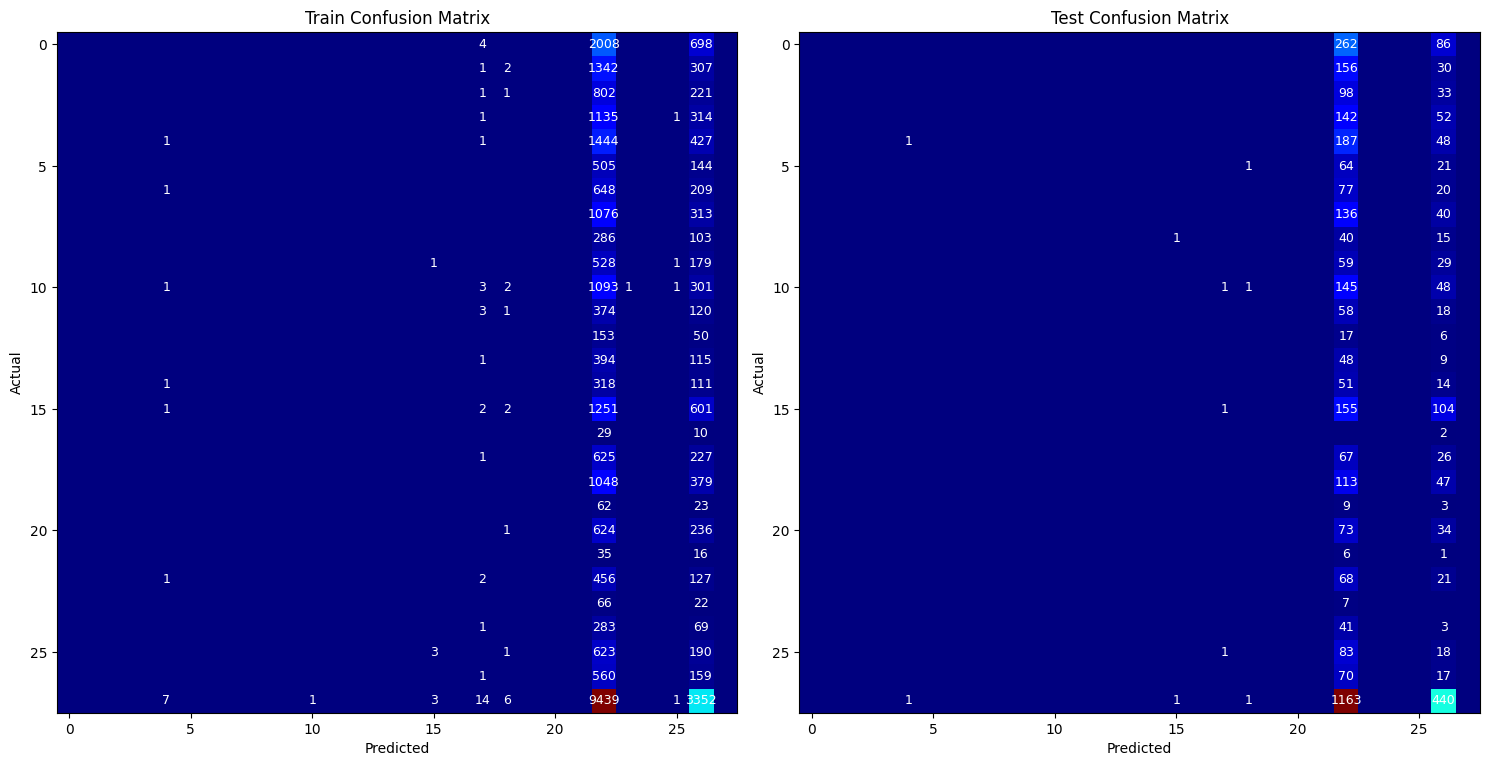

In [ ]:
# Prepare results and confusion matrices
results = {}
confusion_matrices = {}

# Batch evaluation for Train and Test sets
datasets = [("Train", X_train, y_train), ("Test", X_test, y_test)]

# Pre-allocate storage for predictions and probabilities
y_trues, y_preds, y_probs = {}, {}, {}

for set_name, X, y in datasets:
    y_true, y_pred, y_prob = evaluate_model(model, tokenizer, X, y, batch_size=16)

    # Store predictions and probabilities for later use
    y_trues[set_name] = y_true
    y_preds[set_name] = y_pred
    if set_name == "Test":
        y_probs[set_name] = y_prob

    # Calculate accuracy
    results[set_name] = evaluate_acc(y_true, y_pred)

# Calculate AUC for the Test set
if "Test" in y_probs:
    results["AUC"] = roc_auc_score(y_trues["Test"], y_probs["Test"], multi_class="ovr")

# Compute confusion matrices
confusion_matrices = {
    set_name: confusion_matrix(y_trues[set_name], y_preds[set_name])
    for set_name in ["Train", "Test"]
}

# Print results
print(f"UNTRAINED GPT2 EVALUATION")
print(f"Train accuracy of the model: {results['Train']:.4f}")
print(f"Test accuracy of the model: {results['Test']:.4f}")
print(f"AUC for Test set: {results['AUC']:.4f}")

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
cmap = plt.cm.jet

for i, (set_name, cm) in enumerate(confusion_matrices.items()):
    ax = axes[i]
    ax.imshow(cm, cmap=cmap, interpolation="nearest")
    ax.set_title(f"{set_name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.grid(False)

    # Annotate confusion matrix efficiently using np.ndindex
    for j, k in np.ndindex(cm.shape):
        count = cm[j, k]
        if count > 0:
            ax.text(k, j, str(count), ha="center", va="center", color="white", fontsize=9)

plt.tight_layout()
plt.show()

## Finetune the model

In [ ]:
def save_best_model(trainer, model_dir):
    os.makedirs(model_dir, exist_ok=True)
    trainer.save_model(model_dir)
    tokenizer.save_pretrained(model_dir)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), axis=-1).numpy()
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
def model_train(config, dir=f"./results_trial_"):
    # Load LLM and finetune every layer on GPU
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=28)
    model.config.pad_token_id = model.config.eos_token_id

    training_args = TrainingArguments(
        output_dir=dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=config["learning_rate"],
        per_device_train_batch_size=config["batch_size"],
        num_train_epochs=config["num_epochs"],
        weight_decay=config["weight_decay"],
        logging_dir=f"./logs_trial_",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        disable_tqdm=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # This is for early stopping and to avoid overfitting
    )

    trainer.train()

    eval_results = trainer.evaluate()
    print(eval_results)

In [ ]:
# Ran out of colab disk space once the CV with Ray tune finished.
# This code here executes parameter tuning by running 6 samples along the given search space.
# I save the best configuration and then loaded it for future runs and evaluation

os.environ["WANDB_DISABLED"] = "true"

search_space = {
    "learning_rate": tune.uniform(1e-5, 5e-5),
    "batch_size": tune.choice([32, 64, 128]),
    "num_epochs": tune.choice([5, 15, 20]),
    "weight_decay": tune.uniform(0.01, 0.5),
}

analysis = tune.run(
    model_train,
    resources_per_trial={"gpu": 1},
    config=search_space,
    num_samples=6,
    scheduler=ASHAScheduler(metric="eval_accuracy", mode="max"),
)

best_trial = analysis.get_best_trial("eval_accuracy", mode="max")
best_config = best_trial.config
print(f"Best hyperparams: {best_config}")

model_train(best_config, f'./best_results_dir_')

2024-11-27 12:59:26,288	INFO worker.py:1819 -- Started a local Ray instance.
2024-11-27 12:59:27,360	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-11-27 12:59:27,491	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2024-11-27 12:59:27,495	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+--------------------------------------------------------------------+
| Configuration for experiment     model_train_2024-11-27_12-59-27   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 6                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/model_train_2024-11-27_12-59-27

Trial status: 6 PENDING
Current time: 2024-11-27 12:59:30. Total running time: 2s
Logical resource usage: 0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     batch_size     num_epochs     weight_decay |
+------------------------------------------------------

(pid=15879) 2024-11-27 12:59:35.208597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=15879) 2024-11-27 12:59:35.230139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=15879) 2024-11-27 12:59:35.236569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=15879) 2024-11-27 12:59:36.552171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial model_train_6f206_00000 started with configuration:
+--------------------------------------------------+
| Trial model_train_6f206_00000 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| learning_rate                              4e-05 |
| num_epochs                                    15 |
| weight_decay                             0.45152 |
+--------------------------------------------------+


(model_train pid=15879) Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
(model_train pid=15879) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(model_train pid=15879) /usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
(model_train pid=15879)   warnings.warn(
(model_train pid=15879) Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
(model_train pid=15879) <ipython-input-10-d68d96cabb43>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-27 13:00:00. Total running time: 32s
Logical resource usage: 0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     batch_size     num_epochs     weight_decay |
+-----------------------------------------------------------------------------------------------------+
| model_train_6f206_00000   RUNNING        4.07774e-05            128             15        0.451517  |
| model_train_6f206_00001   PENDING        3.75252e-05             32             15        0.049379  |
| model_train_6f206_00002   PENDING        2.13076e-05            128              5        0.377185  |
| model_train_6f206_00003   PENDING        4.93945e-05            128             15        0.354615  |
| model_train_6f206_00004   PENDING        2.03081e-05             32             15        0.0222

(pid=20895) 2024-11-27 13:18:31.191551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=20895) 2024-11-27 13:18:31.213686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=20895) 2024-11-27 13:18:31.220282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=20895) 2024-11-27 13:18:32.524961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial model_train_6f206_00001 started with configuration:
+--------------------------------------------------+
| Trial model_train_6f206_00001 config             |
+--------------------------------------------------+
| batch_size                                    32 |
| learning_rate                              4e-05 |
| num_epochs                                    15 |
| weight_decay                             0.04938 |
+--------------------------------------------------+


(model_train pid=20895) Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
(model_train pid=20895) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(model_train pid=20895) /usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
(model_train pid=20895)   warnings.warn(
(model_train pid=20895) Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
(model_train pid=20895) <ipython-input-10-d68d96cabb43>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Trial status: 1 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-11-27 13:19:01. Total running time: 19min 33s
Logical resource usage: 0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     num_epochs     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_runtime     ...amples_per_second |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| model_train_6f206_00001   RUNNING          3.75252e-05             32             15        0.049379                                                                               

(pid=26430) 2024-11-27 13:39:27.363562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=26430) 2024-11-27 13:39:27.385474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=26430) 2024-11-27 13:39:27.392140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=26430) 2024-11-27 13:39:28.805046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial model_train_6f206_00002 started with configuration:
+--------------------------------------------------+
| Trial model_train_6f206_00002 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| learning_rate                              2e-05 |
| num_epochs                                     5 |
| weight_decay                             0.37719 |
+--------------------------------------------------+


(model_train pid=26430) Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
(model_train pid=26430) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(model_train pid=26430) /usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
(model_train pid=26430)   warnings.warn(
(model_train pid=26430) Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
(model_train pid=26430) <ipython-input-10-d68d96cabb43>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Trial status: 2 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-11-27 13:39:31. Total running time: 40min 4s
Logical resource usage: 0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     num_epochs     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_runtime     ...amples_per_second |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| model_train_6f206_00002   RUNNING          2.13076e-05            128              5        0.377185                                                                                

(pid=28216) 2024-11-27 13:46:01.209236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=28216) 2024-11-27 13:46:01.230928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=28216) 2024-11-27 13:46:01.237471: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Trial status: 3 TERMINATED | 3 PENDING
Current time: 2024-11-27 13:46:02. Total running time: 46min 34s
Logical resource usage: 0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     num_epochs     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_runtime     ...amples_per_second |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| model_train_6f206_00000   TERMINATED       4.07774e-05            128             15        0.451517         1           1126.91        1.26682          0.621592           7.1966             

(pid=28216) 2024-11-27 13:46:02.529222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial model_train_6f206_00003 started with configuration:
+--------------------------------------------------+
| Trial model_train_6f206_00003 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| learning_rate                              5e-05 |
| num_epochs                                    15 |
| weight_decay                             0.35461 |
+--------------------------------------------------+


(model_train pid=28216) Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
(model_train pid=28216) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(model_train pid=28216) /usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
(model_train pid=28216)   warnings.warn(
(model_train pid=28216) Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
(model_train pid=28216) <ipython-input-10-d68d96cabb43>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Trial status: 3 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-11-27 13:46:32. Total running time: 47min 4s
Logical resource usage: 0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     num_epochs     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_runtime     ...amples_per_second |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| model_train_6f206_00003   RUNNING          4.93945e-05            128             15        0.354615                                                                                

(pid=33220) 2024-11-27 14:04:56.502473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=33220) 2024-11-27 14:04:56.523972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=33220) 2024-11-27 14:04:56.530481: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=33220) 2024-11-27 14:04:57.832465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial model_train_6f206_00004 started with configuration:
+--------------------------------------------------+
| Trial model_train_6f206_00004 config             |
+--------------------------------------------------+
| batch_size                                    32 |
| learning_rate                              2e-05 |
| num_epochs                                    15 |
| weight_decay                             0.02229 |
+--------------------------------------------------+


(model_train pid=33220) Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
(model_train pid=33220) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(model_train pid=33220) /usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
(model_train pid=33220)   warnings.warn(
(model_train pid=33220) Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
(model_train pid=33220) <ipython-input-10-d68d96cabb43>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-27 14:05:02. Total running time: 1hr 5min 35s
Logical resource usage: 0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     num_epochs     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_runtime     ...amples_per_second |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| model_train_6f206_00004   RUNNING          2.03081e-05             32             15        0.0222857                                                                           

2024-11-27 14:06:27,007	WARNING util.py:201 -- The `on_step_begin` operation took 1.257 s, which may be a performance bottleneck.


Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-27 14:06:33. Total running time: 1hr 7min 5s
Logical resource usage: 0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     num_epochs     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_runtime     ...amples_per_second |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| model_train_6f206_00004   RUNNING          2.03081e-05             32             15        0.0222857                                                                             

(pid=38760) 2024-11-27 14:25:54.516412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=38760) 2024-11-27 14:25:54.523040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=38760) 2024-11-27 14:25:54.494429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=38760) 2024-11-27 14:25:55.911744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial model_train_6f206_00005 started with configuration:
+--------------------------------------------------+
| Trial model_train_6f206_00005 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| learning_rate                              4e-05 |
| num_epochs                                    20 |
| weight_decay                             0.47187 |
+--------------------------------------------------+


(model_train pid=38760) Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
(model_train pid=38760) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(model_train pid=38760) /usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
(model_train pid=38760)   warnings.warn(
(model_train pid=38760) Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
(model_train pid=38760) <ipython-input-10-d68d96cabb43>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-27 14:26:03. Total running time: 1hr 26min 36s
Logical resource usage: 0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     num_epochs     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_runtime     ...amples_per_second |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| model_train_6f206_00005   RUNNING          4.17981e-05            128             20        0.471866                                                                                       

2024-11-27 14:51:00,959	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/model_train_2024-11-27_12-59-27' in 0.0053s.



Trial model_train_6f206_00005 finished iteration 1 at 2024-11-27 14:51:00. Total running time: 1hr 51min 33s
+--------------------------------------------------+
| Trial model_train_6f206_00005 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         1502.48 |
| time_total_s                             1502.48 |
| training_iteration                             1 |
| epoch                                         20 |
| eval_accuracy                            0.61719 |
| eval_loss                                1.26928 |
| eval_runtime                              7.3054 |
| eval_samples_per_second                  622.555 |
| eval_steps_per_second                     77.888 |
+--------------------------------------------------+

Trial model_train_6f206_00005 completed after 1 iterations at 2024-11-27 14:51:00. Total running time: 1hr 51min 33s

Trial status: 6 TERMINATED
Cu

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-10-d68d96cabb43>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 2.1072, 'grad_norm': 8.161422729492188, 'learning_rate': 3.642314956574238e-05, 'epoch': 0.44052863436123346}
{'loss': 1.4786, 'grad_norm': 8.117902755737305, 'learning_rate': 3.5321087551650326e-05, 'epoch': 0.8810572687224669}
{'eval_loss': 1.2885520458221436, 'eval_accuracy': 0.6189533861037819, 'eval_runtime': 7.1045, 'eval_samples_per_second': 640.154, 'eval_steps_per_second': 80.09, 'epoch': 1.0}
{'loss': 1.2967, 'grad_norm': 9.16204833984375, 'learning_rate': 3.421902553755827e-05, 'epoch': 1.3215859030837005}
{'loss': 1.2489, 'grad_norm': 10.129900932312012, 'learning_rate': 3.311696352346622e-05, 'epoch': 1.7621145374449338}
{'eval_loss': 1.2320291996002197, 'eval_accuracy': 0.6281882145998241, 'eval_runtime': 7.0241, 'eval_samples_per_second': 647.487, 'eval_steps_per_second': 81.007, 'epoch': 2.0}
{'loss': 1.1474, 'grad_norm': 9.764311790466309, 'learning_rate': 3.2014901509374166e-05, 'epoch': 2.202643171806167}
{'loss': 1.0838, 'grad_norm': 12.408181190490723, 'le

/usr/local/lib/python3.10/dist-packages/ray/train/_internal/session.py:652: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


In [ ]:
# Do not have to run this, just in case we run out of runtime, we can simply start from here with previously found best params
os.environ["WANDB_DISABLED"] = "true"
config_best = {
    'learning_rate': 3.7525211579834433e-05,
    'batch_size': 32,
    'num_epochs': 15,
    'weight_decay': 0.0493790360136133
}

model_train(config_best)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-17-224dc61268ac>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 2.05, 'grad_norm': 7.295462131500244, 'learning_rate': 3.642314956574238e-05, 'epoch': 0.44052863436123346}
{'loss': 1.4675, 'grad_norm': 6.606855392456055, 'learning_rate': 3.5321087551650326e-05, 'epoch': 0.8810572687224669}
{'eval_loss': 1.305814266204834, 'eval_accuracy': 0.6156552330694811, 'eval_runtime': 7.0667, 'eval_samples_per_second': 643.585, 'eval_steps_per_second': 80.519, 'epoch': 1.0}
{'loss': 1.2906, 'grad_norm': 8.715043067932129, 'learning_rate': 3.421902553755827e-05, 'epoch': 1.3215859030837005}
{'loss': 1.2432, 'grad_norm': 9.640589714050293, 'learning_rate': 3.311696352346622e-05, 'epoch': 1.7621145374449338}
{'eval_loss': 1.2412551641464233, 'eval_accuracy': 0.6268689533861038, 'eval_runtime': 7.0525, 'eval_samples_per_second': 644.878, 'eval_steps_per_second': 80.681, 'epoch': 2.0}
{'loss': 1.1456, 'grad_norm': 9.24445915222168, 'learning_rate': 3.2014901509374166e-05, 'epoch': 2.202643171806167}
{'loss': 1.0809, 'grad_norm': 11.008819580078125, 'learn

In [ ]:
best_model_dir = f'./best_results_dir_'

## Save best model

## Load model and tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(best_model_dir)
model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)

## Evaluate the models

In [ ]:
invalid_elements = [text for text in X_train if not isinstance(text, str)]
print("Invalid elements in X:", invalid_elements)

Invalid elements in X: []


cuda


100%|██████████| 2270/2270 [02:04<00:00, 18.30it/s]


cuda


100%|██████████| 287/287 [00:10<00:00, 26.90it/s]


Train accuracy of the model: 0.8480
Test accuracy of the model: 0.5959
AUC for Test set: 0.9186


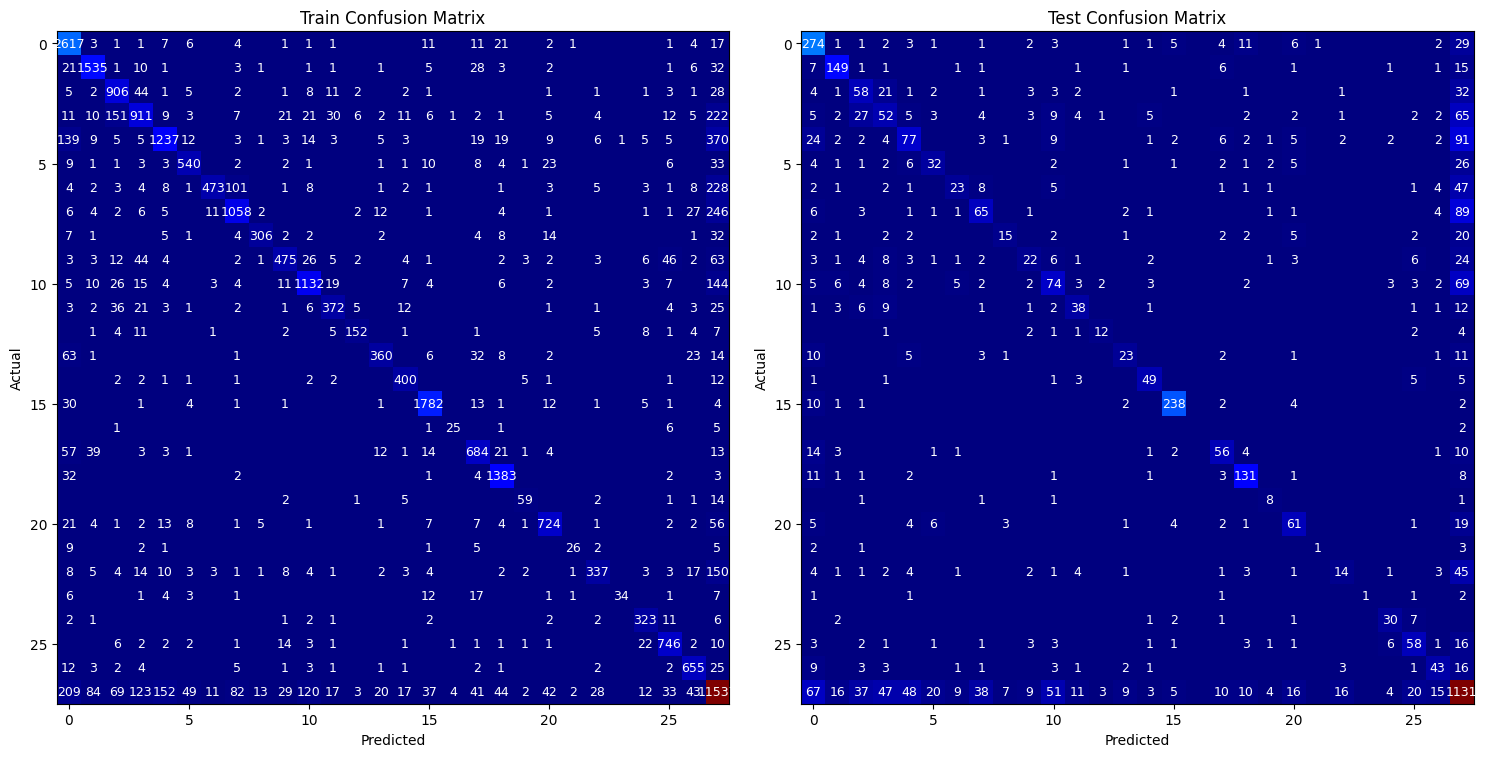

In [ ]:
# Prepare results and confusion matrices
results = {}
confusion_matrices = {}

# Batch evaluation for Train and Test sets
datasets = [("Train", X_train, y_train), ("Test", X_test, y_test)]

# Pre-allocate storage for predictions and probabilities
y_trues, y_preds, y_probs = {}, {}, {}

for set_name, X, y in datasets:
    y_true, y_pred, y_prob = evaluate_model(model, tokenizer, X, y, batch_size=16)

    # Store predictions and probabilities for later use
    y_trues[set_name] = y_true
    y_preds[set_name] = y_pred
    if set_name == "Test":
        y_probs[set_name] = y_prob

    # Calculate accuracy
    results[set_name] = evaluate_acc(y_true, y_pred)

# Calculate AUC for the Test set
if "Test" in y_probs:
    results["AUC"] = roc_auc_score(y_trues["Test"], y_probs["Test"], multi_class="ovr")

# Compute confusion matrices
confusion_matrices = {
    set_name: confusion_matrix(y_trues[set_name], y_preds[set_name])
    for set_name in ["Train", "Test"]
}

# Print results
print(f"Train accuracy of the model: {results['Train']:.4f}")
print(f"Test accuracy of the model: {results['Test']:.4f}")
print(f"AUC for Test set: {results['AUC']:.4f}")

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
cmap = plt.cm.jet

for i, (set_name, cm) in enumerate(confusion_matrices.items()):
    ax = axes[i]
    ax.imshow(cm, cmap=cmap, interpolation="nearest")
    ax.set_title(f"{set_name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.grid(False)

    # Annotate confusion matrix efficiently using np.ndindex
    for j, k in np.ndindex(cm.shape):
        count = cm[j, k]
        if count > 0:
            ax.text(k, j, str(count), ha="center", va="center", color="white", fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
!zip -r best_model.zip results_trial_/checkpoint-5675/

  adding: results_trial_/checkpoint-5675/ (stored 0%)
  adding: results_trial_/checkpoint-5675/rng_state.pth (deflated 25%)
  adding: results_trial_/checkpoint-5675/tokenizer_config.json (deflated 54%)
  adding: results_trial_/checkpoint-5675/special_tokens_map.json (deflated 60%)
  adding: results_trial_/checkpoint-5675/trainer_state.json (deflated 70%)
  adding: results_trial_/checkpoint-5675/tokenizer.json (deflated 82%)
  adding: results_trial_/checkpoint-5675/merges.txt (deflated 53%)
  adding: results_trial_/checkpoint-5675/vocab.json (deflated 59%)
  adding: results_trial_/checkpoint-5675/model.safetensors (deflated 7%)
  adding: results_trial_/checkpoint-5675/training_args.bin (deflated 51%)
  adding: results_trial_/checkpoint-5675/scheduler.pt (deflated 55%)
  adding: results_trial_/checkpoint-5675/config.json (deflated 65%)
  adding: results_trial_/checkpoint-5675/optimizer.pt (deflated 23%)


In [ ]:
from google.colab import files
files.download("best_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>